# 🌤️ DBSCAN Weather Station Clustering

This notebook demonstrates DBSCAN clustering for weather station analysis with:
- **Data Cleaning** and **Feature Selection**
- **Outlier Detection** and **Visualization**
- **Parameter Optimization** (eps, min_samples)
- **Geographic and Climate Pattern Analysis**

## 🎯 Goal: Group weather stations by climate patterns and identify outliers

## 1. Import Libraries & Create Dataset

In [43]:
# Essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [44]:
# Create structured weather station dataset with distinct climate zones
np.random.seed(42)
n_stations = 200

# Define 5 distinct climate zones with realistic characteristics
climate_zones = {
    'Tropical': {
        'count': 40,
        'temp_range': (25, 32),
        'rainfall_range': (1500, 3000),
        'humidity_range': (70, 90),
        'elevation_range': (0, 500),
        'lat_range': (-20, 20),
        'pressure_range': (1008, 1015)
    },
    'Arid': {
        'count': 35,
        'temp_range': (20, 35),
        'rainfall_range': (50, 300),
        'humidity_range': (20, 40),
        'elevation_range': (200, 1000),
        'lat_range': (15, 40),
        'pressure_range': (1010, 1020)
    },
    'Temperate': {
        'count': 50,
        'temp_range': (8, 18),
        'rainfall_range': (600, 1200),
        'humidity_range': (50, 70),
        'elevation_range': (0, 800),
        'lat_range': (30, 50),
        'pressure_range': (1012, 1018)
    },
    'Cold': {
        'count': 40,
        'temp_range': (-5, 8),
        'rainfall_range': (300, 800),
        'humidity_range': (60, 80),
        'elevation_range': (100, 1500),
        'lat_range': (50, 70),
        'pressure_range': (1015, 1025)
    },
    'Alpine': {
        'count': 25,
        'temp_range': (-10, 5),
        'rainfall_range': (800, 1500),
        'humidity_range': (65, 85),
        'elevation_range': (1500, 4000),
        'lat_range': (35, 65),
        'pressure_range': (950, 1000)
    }
}

# Generate structured data
all_data = []
station_id = 1

for zone_name, zone_params in climate_zones.items():
    count = zone_params['count']
    
    for i in range(count):
        # Add some natural variation within each zone
        temp = np.random.uniform(*zone_params['temp_range'])
        rainfall = np.random.uniform(*zone_params['rainfall_range'])
        humidity = np.random.uniform(*zone_params['humidity_range'])
        elevation = np.random.uniform(*zone_params['elevation_range'])
        latitude = np.random.uniform(*zone_params['lat_range'])
        pressure = np.random.uniform(*zone_params['pressure_range'])
        
        # Derived features with realistic relationships
        longitude = np.random.uniform(-180, 180)
        wind_speed = np.random.exponential(5) + (elevation / 1000)  # Higher elevation = more wind
        sunshine_hours = 3500 - (rainfall * 0.5) + np.random.normal(0, 200)  # Less rain = more sun
        sunshine_hours = np.clip(sunshine_hours, 1200, 3500)
        
        station_data = {
            'Station_ID': f'WS_{station_id:03d}',
            'Latitude': latitude,
            'Longitude': longitude,
            'Elevation': elevation,
            'Avg_Temperature': temp,
            'Annual_Rainfall': rainfall,
            'Humidity': humidity,
            'Wind_Speed': wind_speed,
            'Sunshine_Hours': sunshine_hours,
            'Pressure': pressure,
            'True_Zone': zone_name  # For validation
        }
        
        all_data.append(station_data)
        station_id += 1

# Create DataFrame
df = pd.DataFrame(all_data)

# Add some missing values (realistic amount)
missing_indices = np.random.choice(df.index, size=int(0.03 * len(df)), replace=False)
for idx in missing_indices:
    col = np.random.choice(['Humidity', 'Wind_Speed', 'Sunshine_Hours'])
    df.loc[idx, col] = np.nan

# Add a few extreme outliers (weather anomalies)
outlier_indices = np.random.choice(df.index, size=8, replace=False)
for idx in outlier_indices:
    # Create extreme weather conditions
    if np.random.random() > 0.5:
        df.loc[idx, 'Avg_Temperature'] = np.random.choice([-35, 45])  # Extreme temperatures
        df.loc[idx, 'Annual_Rainfall'] = np.random.choice([10, 4500])  # Extreme rainfall
    df.loc[idx, 'True_Zone'] = 'Outlier'  # Mark as outlier for validation

print("🌤️ Weather Station Dataset Created:")
print(f"  Stations: {len(df)}")
print(f"  Features: {len(df.columns)-1}")
display(df.head())
print(df.info())

🌤️ Weather Station Dataset Created:
  Stations: 190
  Features: 10


,Station_ID,Latitude,Longitude,Elevation,Avg_Temperature,Annual_Rainfall,Humidity,Wind_Speed,Sunshine_Hours,Pressure,True_Zone
0,WS_001,-13.759254,-159.089900,299.329242,27.621781,2926.071460,84.639879,10.355484,2352.806833,1009.091962,Tropical
1,WS_002,-12.727001,-70.472793,106.169555,25.144091,2954.864778,86.648853,3.825809,2176.054557,1009.283832,Outlier
2,WS_003,-8.314214,-15.814806,69.746930,28.023615,1936.843710,82.237058,7.759427,2545.083786,1010.564533,Tropical
3,WS_004,-17.397936,167.627532,85.262062,29.146902,1569.675619,82.150897,8.346920,2430.212553,1014.642199,Tropical
4,WS_005,-15.118471,-167.620132,220.076247,27.132296,1646.508171,83.684661,12.222191,2841.254897,1011.466238,Tropical


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Station_ID       190 non-null    object 
 1   Latitude         190 non-null    float64
 2   Longitude        190 non-null    float64
 3   Elevation        190 non-null    float64
 4   Avg_Temperature  190 non-null    float64
 5   Annual_Rainfall  190 non-null    float64
 6   Humidity         188 non-null    float64
 7   Wind_Speed       189 non-null    float64
 8   Sunshine_Hours   188 non-null    float64
 9   Pressure         190 non-null    float64
 10  True_Zone        190 non-null    object 
dtypes: float64(9), object(2)
memory usage: 16.5+ KB
None


## 2. Data Cleaning

In [45]:
# Data cleaning process
print("🧹 DATA CLEANING PROCESS")
print("=" * 30)

# Check for missing values
print("🔍 Missing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Handle missing values
numeric_columns = df.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    if df[col].isnull().sum() > 0:
        median_value = df[col].median()
        df[col].fillna(median_value, inplace=True)
        print(f"  ✅ {col}: Filled with median ({median_value:.2f})")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\n🔍 Duplicate Records: {duplicates}")
if duplicates > 0:
    df.drop_duplicates(inplace=True)

print(f"\n📊 Clean Dataset Shape: {df.shape}")
print("✅ Data cleaning complete!")

🧹 DATA CLEANING PROCESS
🔍 Missing Values:
Humidity          2
Wind_Speed        1
Sunshine_Hours    2
dtype: int64
  ✅ Humidity: Filled with median (67.62)
  ✅ Wind_Speed: Filled with median (4.26)
  ✅ Sunshine_Hours: Filled with median (3066.97)

🔍 Duplicate Records: 0

📊 Clean Dataset Shape: (190, 11)
✅ Data cleaning complete!


## 3. Feature Selection & Engineering

In [46]:
# Feature selection and engineering
print("🔧 FEATURE SELECTION & ENGINEERING")
print("=" * 40)

# Select relevant features for clustering (exclude True_Zone - that's for validation)
climate_features = [
    'Avg_Temperature', 'Annual_Rainfall', 'Humidity', 
    'Wind_Speed', 'Sunshine_Hours', 'Pressure'
]

# Engineer additional features that help distinguish climate zones
df['Temp_Humidity_Ratio'] = df['Avg_Temperature'] / (df['Humidity'] + 1)  # Avoid division by zero
df['Aridity_Index'] = df['Avg_Temperature'] / (df['Annual_Rainfall'] / 1000 + 1)  # Temperature vs rainfall
df['Elevation_Pressure_Ratio'] = df['Elevation'] / (df['Pressure'] - 900)  # Elevation effect on pressure

# Final features for clustering
clustering_features = climate_features + ['Elevation', 'Temp_Humidity_Ratio', 'Aridity_Index']

print(f"🎯 Features for Clustering:")
for i, feature in enumerate(clustering_features, 1):
    print(f"  {i}. {feature}")

display(df[clustering_features].describe())

🔧 FEATURE SELECTION & ENGINEERING
🎯 Features for Clustering:
  1. Avg_Temperature
  2. Annual_Rainfall
  3. Humidity
  4. Wind_Speed
  5. Sunshine_Hours
  6. Pressure
  7. Elevation
  8. Temp_Humidity_Ratio
  9. Aridity_Index


,Avg_Temperature,Annual_Rainfall,Humidity,Wind_Speed,Sunshine_Hours,Pressure,Elevation,Temp_Humidity_Ratio,Aridity_Index
count,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000
mean,13.372851,1102.502665,62.688779,6.057976,2988.760746,1009.711589,769.649942,0.290742,7.459755
std,14.617045,894.162528,18.656552,5.247884,379.237013,16.136098,844.163603,0.378494,9.126181
min,-35.000000,10.000000,20.243089,0.313814,1966.466570,953.007117,3.705618,-0.565293,-34.653465
25%,3.051660,554.749904,54.209563,2.063507,2761.478566,1011.501382,239.974116,0.041228,1.858404
50%,11.841089,887.047942,67.622352,4.261234,3066.968422,1014.574400,488.211037,0.200042,6.249197
75%,27.106287,1424.605947,76.135762,8.552427,3295.325054,1017.009664,857.976063,0.373930,9.783183
max,45.000000,4500.000000,89.248946,28.840630,3500.000000,1024.811862,3978.139984,1.551787,29.761194


## 4. Data Preprocessing for DBSCAN

In [47]:
# Prepare data for DBSCAN
X = df[clustering_features].values

# Scale the features (crucial for DBSCAN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("🔧 Data Preprocessing for DBSCAN:")
print(f"  Shape: {X_scaled.shape}")
print(f"  Features: {clustering_features}")
print(f"  Scaled range: [{X_scaled.min():.2f}, {X_scaled.max():.2f}]")
print("\n✅ Data ready for DBSCAN clustering!")

🔧 Data Preprocessing for DBSCAN:
  Shape: (190, 9)
  Features: ['Avg_Temperature', 'Annual_Rainfall', 'Humidity', 'Wind_Speed', 'Sunshine_Hours', 'Pressure', 'Elevation', 'Temp_Humidity_Ratio', 'Aridity_Index']
  Scaled range: [-4.63, 4.35]

✅ Data ready for DBSCAN clustering!


## 5. DBSCAN Parameter Optimization

🔍 Finding Optimal DBSCAN Parameters...


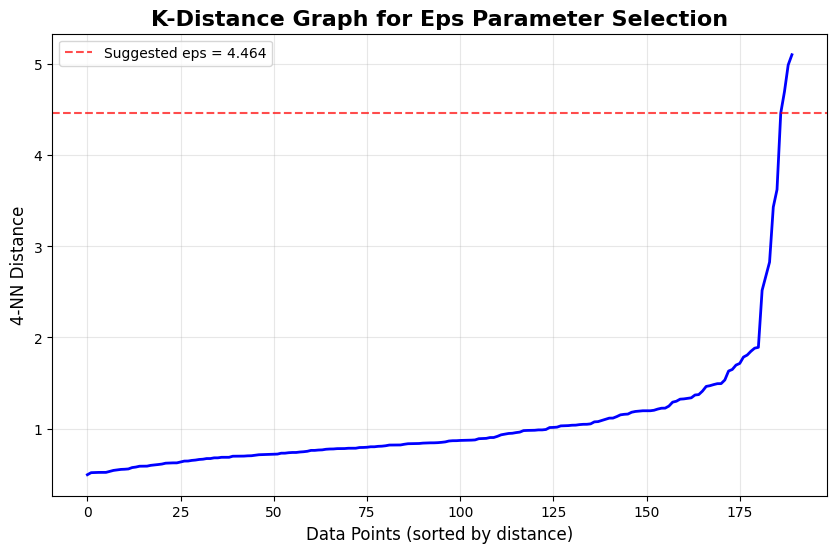

📊 K-Distance Analysis:
  • Suggested eps: 4.464
  • Elbow point at index: 186


In [48]:
# Find optimal eps parameter using k-distance graph
print("🔍 Finding Optimal DBSCAN Parameters...")
print("=" * 40)

# Calculate k-distance for eps estimation
k = 4
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort distances
distances = np.sort(distances[:, k-1], axis=0)

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances, 'b-', linewidth=2)
plt.title('K-Distance Graph for Eps Parameter Selection', fontsize=16, fontweight='bold')
plt.xlabel('Data Points (sorted by distance)', fontsize=12)
plt.ylabel(f'{k}-NN Distance', fontsize=12)
plt.grid(True, alpha=0.3)

# Find elbow point
diff = np.diff(distances)
diff2 = np.diff(diff)
elbow_idx = np.argmax(diff2) + 2
optimal_eps = distances[elbow_idx]

plt.axhline(y=optimal_eps, color='red', linestyle='--', alpha=0.7,
           label=f'Suggested eps = {optimal_eps:.3f}')
plt.legend()
plt.show()

print(f"📊 K-Distance Analysis:")
print(f"  • Suggested eps: {optimal_eps:.3f}")
print(f"  • Elbow point at index: {elbow_idx}")

In [49]:
# Test different parameter combinations with better eps range
# Use a more reasonable range around the median distance
median_distance = np.median(distances)
eps_values = [0.8, 1.0, 1.2, 1.5, 2.0, 2.5]
min_samples_values = [3, 4, 5, 6]

print(f"📊 Median k-distance: {median_distance:.3f}")
print(f"🎯 Testing eps values around median distance")

print(f"🧪 Testing Parameter Combinations:")
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_outliers = list(labels).count(-1)
        
        # Calculate silhouette score
        if n_clusters > 1 and n_outliers < len(labels) - 1:
            mask = labels != -1
            if np.sum(mask) > 1:
                silhouette_avg = silhouette_score(X_scaled[mask], labels[mask])
            else:
                silhouette_avg = -1
        else:
            silhouette_avg = -1
        
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_outliers': n_outliers,
            'silhouette_score': silhouette_avg
        })
        
        print(f"  eps={eps:.2f}, min_samples={min_samples}: "
              f"{n_clusters} clusters, {n_outliers} outliers, "
              f"silhouette={silhouette_avg:.3f}")

# Find best parameters with improved selection criteria
results_df = pd.DataFrame(results)

# Filter for reasonable results
reasonable_results = results_df[
    (results_df['silhouette_score'] > 0) &  # Valid silhouette score
    (results_df['n_clusters'] >= 2) &       # At least 2 clusters
    (results_df['n_clusters'] <= 10) &      # Not too many clusters
    (results_df['n_outliers'] < len(df) * 0.5)  # Less than 50% outliers
]

if len(reasonable_results) > 0:
    # Score based on silhouette score and outlier percentage
    reasonable_results = reasonable_results.copy()
    reasonable_results['outlier_ratio'] = reasonable_results['n_outliers'] / len(df)
    reasonable_results['combined_score'] = (
        reasonable_results['silhouette_score'] * 0.7 - 
        reasonable_results['outlier_ratio'] * 0.3
    )
    
    best_params = reasonable_results.loc[reasonable_results['combined_score'].idxmax()]
    print(f"\n🏆 Best Parameters:")
    print(f"  eps: {best_params['eps']}")
    print(f"  min_samples: {best_params['min_samples']}")
    print(f"  Silhouette Score: {best_params['silhouette_score']:.3f}")
    print(f"  Outlier Ratio: {best_params['outlier_ratio']:.1%}")
else:
    # Fallback to any result with valid clusters
    fallback_results = results_df[
        (results_df['n_clusters'] >= 2) & 
        (results_df['n_outliers'] < len(df) * 0.8)
    ]
    
    if len(fallback_results) > 0:
        best_params = fallback_results.iloc[0]
        print(f"\n🎯 Using Fallback Parameters:")
        print(f"  eps: {best_params['eps']}")
        print(f"  min_samples: {best_params['min_samples']}")
        print(f"  Note: Using fallback due to limited good options")
    else:
        best_params = {'eps': 1.5, 'min_samples': 4}
        print(f"\n⚠️ Using Default Parameters:")
        print(f"  eps: {best_params['eps']}")
        print(f"  min_samples: {best_params['min_samples']}")
        print(f"  Note: No good parameter combinations found")

📊 Median k-distance: 0.847
🎯 Testing eps values around median distance
🧪 Testing Parameter Combinations:
  eps=0.80, min_samples=3: 8 clusters, 69 outliers, silhouette=0.239
  eps=0.80, min_samples=4: 10 clusters, 76 outliers, silhouette=0.233
  eps=0.80, min_samples=5: 8 clusters, 93 outliers, silhouette=0.278
  eps=0.80, min_samples=6: 2 clusters, 126 outliers, silhouette=0.590
  eps=1.00, min_samples=3: 7 clusters, 37 outliers, silhouette=0.419
  eps=1.00, min_samples=4: 5 clusters, 46 outliers, silhouette=0.436
  eps=1.00, min_samples=5: 5 clusters, 49 outliers, silhouette=0.434
  eps=1.00, min_samples=6: 3 clusters, 61 outliers, silhouette=0.542
  eps=1.20, min_samples=3: 3 clusters, 19 outliers, silhouette=0.460
  eps=1.20, min_samples=4: 3 clusters, 23 outliers, silhouette=0.452
  eps=1.20, min_samples=5: 3 clusters, 26 outliers, silhouette=0.446
  eps=1.20, min_samples=6: 3 clusters, 29 outliers, silhouette=0.449
  eps=1.50, min_samples=3: 4 clusters, 11 outliers, silhouette=0.

## 6. Apply DBSCAN Clustering

In [50]:
# Apply DBSCAN with optimal parameters
print("🚀 Applying DBSCAN Clustering...")
print("=" * 35)

# Use best parameters (ensure correct types)
final_eps = float(best_params['eps'])
final_min_samples = int(best_params['min_samples'])

# Apply DBSCAN
dbscan_final = DBSCAN(eps=final_eps, min_samples=final_min_samples)
cluster_labels = dbscan_final.fit_predict(X_scaled)

# Add results to dataframe
df['Cluster'] = cluster_labels
df['Is_Outlier'] = (cluster_labels == -1)

# Analyze results
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_outliers = list(cluster_labels).count(-1)
n_core_samples = len(dbscan_final.core_sample_indices_)

print(f"📊 DBSCAN Results:")
print(f"  • Parameters: eps={final_eps:.3f}, min_samples={final_min_samples}")
print(f"  • Number of clusters: {n_clusters}")
print(f"  • Number of outliers: {n_outliers} ({n_outliers/len(df)*100:.1f}%)")
print(f"  • Core samples: {n_core_samples}")
print(f"  • Border samples: {len(df) - n_core_samples - n_outliers}")

# Cluster distribution
if n_clusters > 0:
    cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
    print(f"\n📈 Cluster Distribution:")
    for cluster, count in cluster_counts.items():
        if cluster != -1:
            print(f"  Cluster {cluster}: {count} stations ({count/len(df)*100:.1f}%)")
        else:
            print(f"  Outliers: {count} stations ({count/len(df)*100:.1f}%)")

print("\n✅ DBSCAN clustering complete!")

🚀 Applying DBSCAN Clustering...
📊 DBSCAN Results:
  • Parameters: eps=1.500, min_samples=4
  • Number of clusters: 3
  • Number of outliers: 14 (7.4%)
  • Core samples: 171
  • Border samples: 5

📈 Cluster Distribution:
  Outliers: 14 stations (7.4%)
  Cluster 0: 125 stations (65.8%)
  Cluster 1: 33 stations (17.4%)
  Cluster 2: 18 stations (9.5%)

✅ DBSCAN clustering complete!


## 7. Outlier Analysis

In [51]:
# Detailed outlier analysis
print("🔍 OUTLIER ANALYSIS")
print("=" * 25)

outliers = df[df['Is_Outlier'] == True]

if len(outliers) > 0:
    print(f"📊 Outlier Statistics:")
    print(f"  • Total outliers: {len(outliers)}")
    print(f"  • Percentage: {len(outliers)/len(df)*100:.1f}%")
    
    print(f"\n🌡️ Outlier Characteristics:")
    display(outliers[clustering_features].describe())
    
    # Compare outliers to normal stations
    normal_stations = df[df['Is_Outlier'] == False]
    
    print(f"\n📈 Outliers vs Normal Stations:")
    comparison = pd.DataFrame({
        'Outliers_Mean': outliers[clustering_features].mean(),
        'Normal_Mean': normal_stations[clustering_features].mean(),
        'Difference': outliers[clustering_features].mean() - normal_stations[clustering_features].mean()
    })
    display(comparison.round(2))
    
    print(f"\n🚨 Most Extreme Outliers:")
    for idx, station in outliers.head(5).iterrows():
        print(f"  {station['Station_ID']}: Temp={station['Avg_Temperature']:.1f}°C, "
              f"Rainfall={station['Annual_Rainfall']:.0f}mm")
else:
    print("ℹ️ No outliers detected with current parameters.")

🔍 OUTLIER ANALYSIS
📊 Outlier Statistics:
  • Total outliers: 14
  • Percentage: 7.4%

🌡️ Outlier Characteristics:


,Avg_Temperature,Annual_Rainfall,Humidity,Wind_Speed,Sunshine_Hours,Pressure,Elevation,Temp_Humidity_Ratio,Aridity_Index
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,-2.871206,1857.234591,65.606637,13.593936,3103.914417,991.505546,1876.056913,0.049505,-0.068770
std,25.015716,1784.849740,19.102774,9.599854,295.509719,30.310337,1334.041094,0.527690,13.396528
min,-35.000000,10.000000,20.243089,2.016958,2626.428080,953.007117,490.465837,-0.565293,-34.653465
25%,-27.144251,750.539427,63.218950,5.588475,2868.755586,957.767051,702.707353,-0.348215,-5.161141
50%,-0.953527,1238.134519,73.060526,9.950301,3149.939482,1006.028916,1486.762798,-0.012551,-0.469688
75%,4.751830,3700.579609,76.706062,21.299244,3294.211537,1017.220973,3180.448993,0.060953,2.125099
max,45.000000,4500.000000,81.383777,28.840630,3500.000000,1024.688779,3978.139984,1.099366,24.470851



📈 Outliers vs Normal Stations:


,Outliers_Mean,Normal_Mean,Difference
Avg_Temperature,-2.87,14.66,-17.54
Annual_Rainfall,1857.23,1042.47,814.77
Humidity,65.61,62.46,3.15
Wind_Speed,13.59,5.46,8.14
Sunshine_Hours,3103.91,2979.60,124.31
Pressure,991.51,1011.16,-19.65
Elevation,1876.06,681.64,1194.42
Temp_Humidity_Ratio,0.05,0.31,-0.26
Aridity_Index,-0.07,8.06,-8.13



🚨 Most Extreme Outliers:
  WS_052: Temp=23.4°C, Rainfall=291mm
  WS_072: Temp=26.5°C, Rainfall=82mm
  WS_089: Temp=-35.0°C, Rainfall=4500mm
  WS_092: Temp=-35.0°C, Rainfall=10mm
  WS_131: Temp=-35.0°C, Rainfall=4500mm


## 8. Cluster Visualization

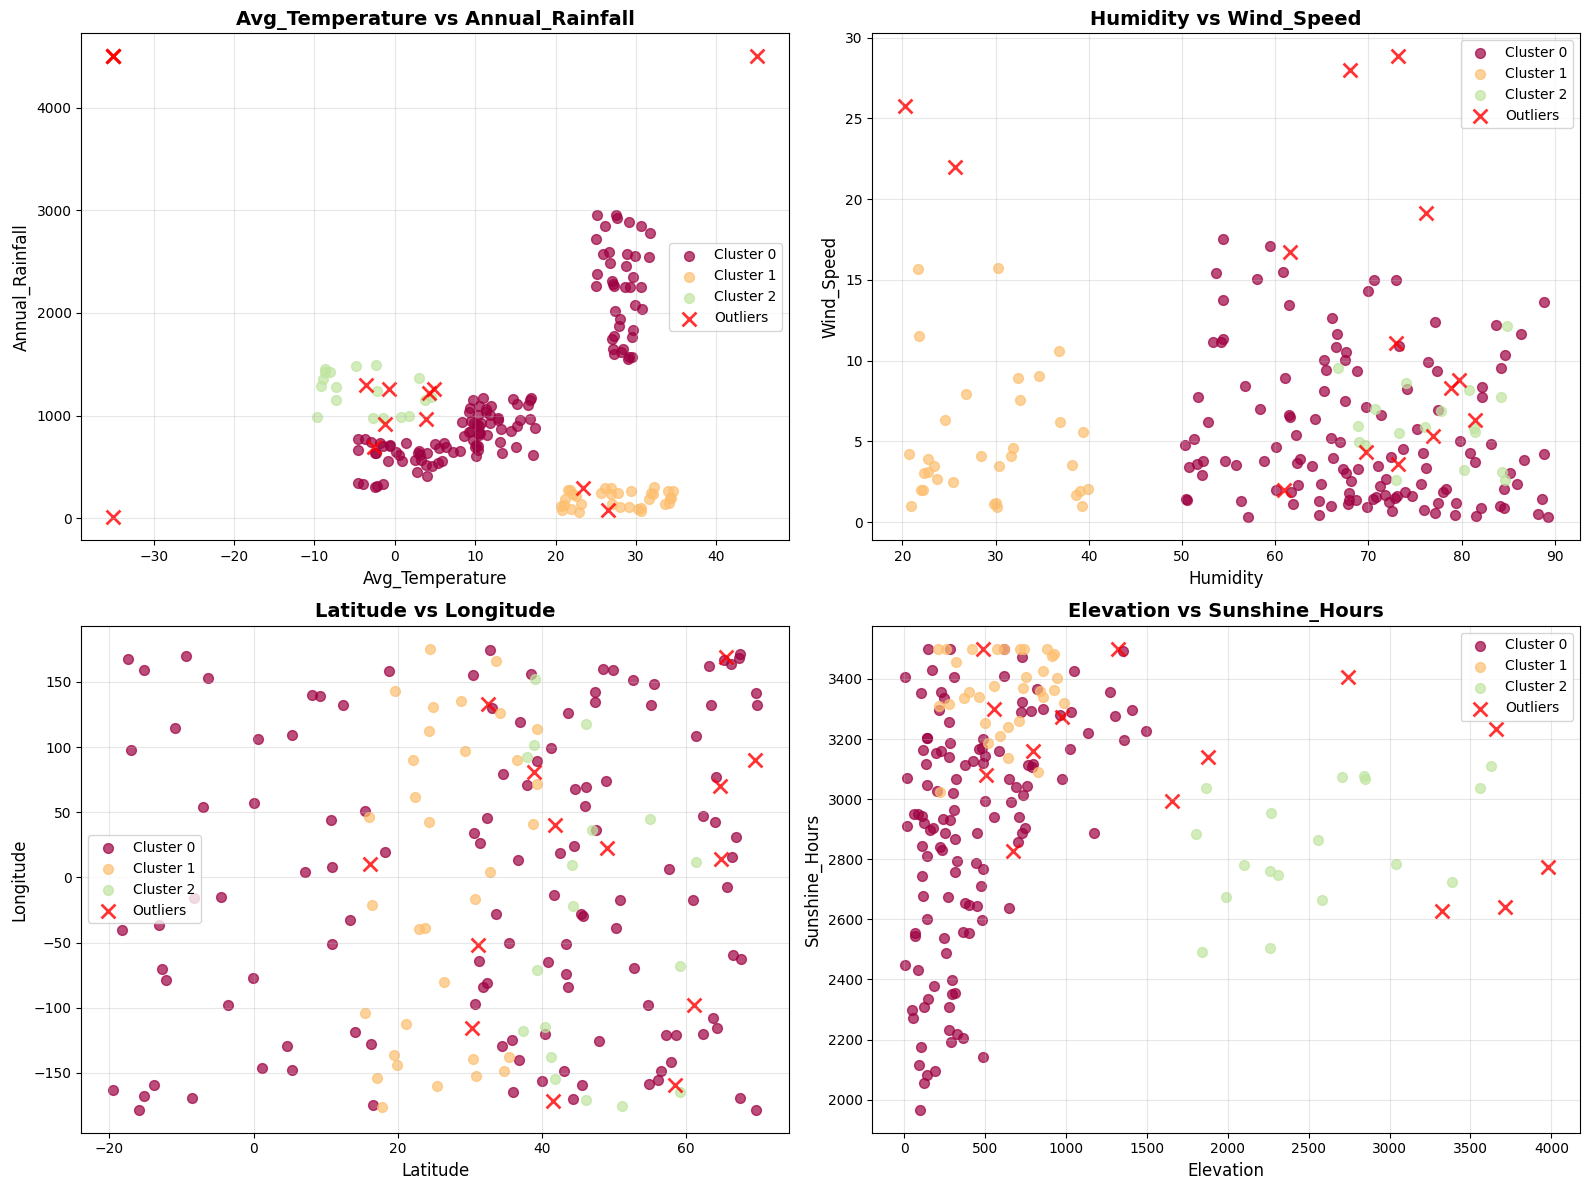

🎨 Cluster visualizations complete!
🔴 Red X marks represent outlier weather stations.


In [52]:
# Visualize clusters and outliers
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Color map for clusters
unique_labels = set(cluster_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
color_map = dict(zip(unique_labels, colors))
color_map[-1] = [0, 0, 0, 1]  # Black for outliers

# Feature pairs for visualization
feature_pairs = [
    ('Avg_Temperature', 'Annual_Rainfall'),
    ('Humidity', 'Wind_Speed'),
    ('Latitude', 'Longitude'),
    ('Elevation', 'Sunshine_Hours')
]

for idx, (feat1, feat2) in enumerate(feature_pairs):
    ax = axes[idx//2, idx%2]
    
    # Plot each cluster
    for cluster in unique_labels:
        if cluster == -1:
            # Plot outliers
            cluster_data = df[df['Cluster'] == cluster]
            ax.scatter(cluster_data[feat1], cluster_data[feat2], 
                      c='red', marker='x', s=100, alpha=0.8, 
                      label='Outliers', linewidths=2)
        else:
            # Plot regular clusters
            cluster_data = df[df['Cluster'] == cluster]
            ax.scatter(cluster_data[feat1], cluster_data[feat2], 
                      c=[color_map[cluster]], label=f'Cluster {cluster}', 
                      alpha=0.7, s=50)
    
    ax.set_xlabel(feat1, fontsize=12)
    ax.set_ylabel(feat2, fontsize=12)
    ax.set_title(f'{feat1} vs {feat2}', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("🎨 Cluster visualizations complete!")
print("🔴 Red X marks represent outlier weather stations.")

## 9. Geographic Visualization

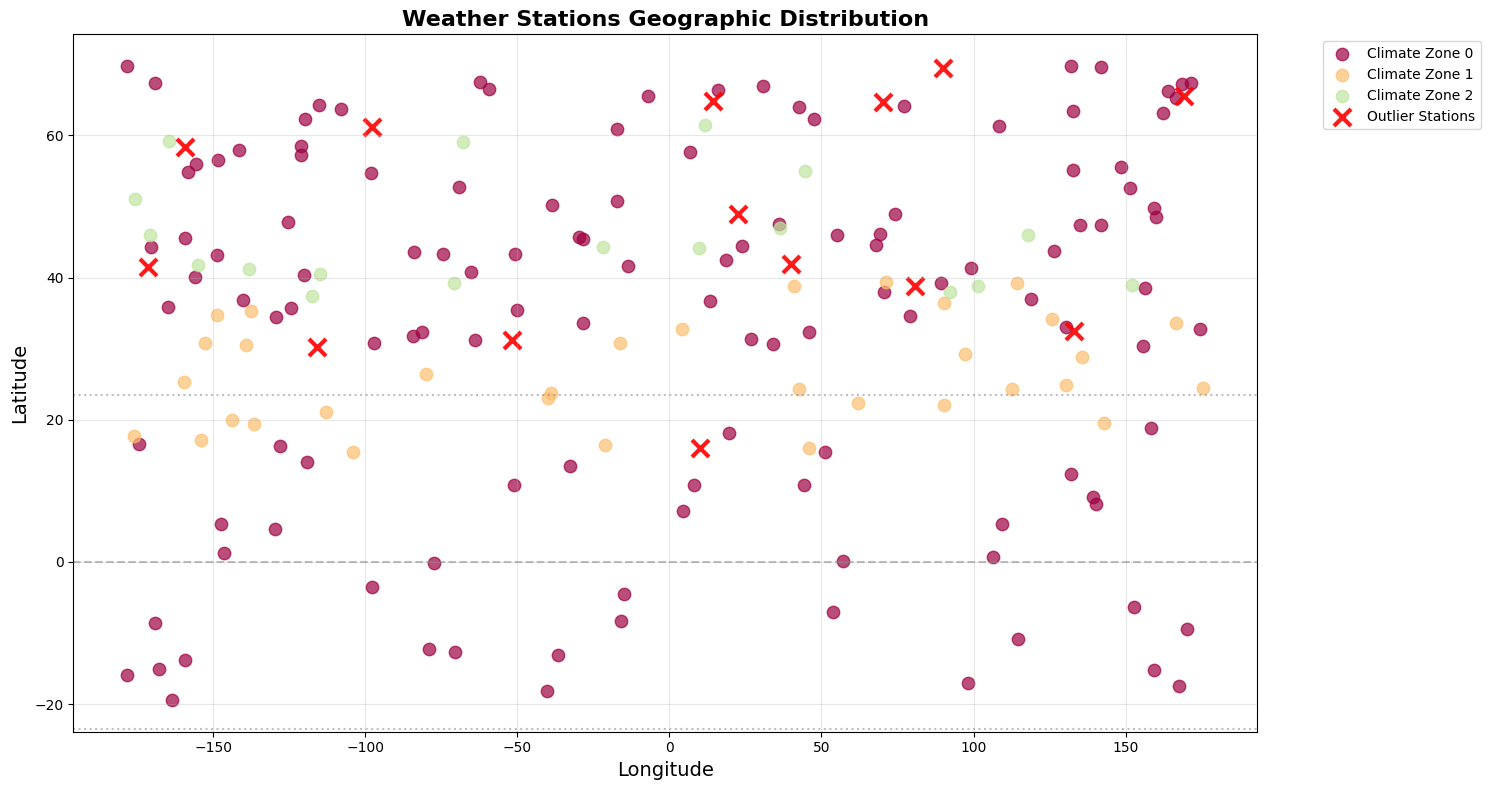

🗺️ Geographic visualization complete!


In [53]:
# Geographic visualization of clusters
plt.figure(figsize=(15, 8))

# Plot world map-like scatter
for cluster in unique_labels:
    if cluster == -1:
        # Plot outliers
        cluster_data = df[df['Cluster'] == cluster]
        plt.scatter(cluster_data['Longitude'], cluster_data['Latitude'], 
                   c='red', marker='x', s=150, alpha=0.9, 
                   label='Outlier Stations', linewidths=3)
    else:
        # Plot regular clusters
        cluster_data = df[df['Cluster'] == cluster]
        plt.scatter(cluster_data['Longitude'], cluster_data['Latitude'], 
                   c=[color_map[cluster]], label=f'Climate Zone {cluster}', 
                   alpha=0.7, s=80)

plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.title('Weather Stations Geographic Distribution', fontsize=16, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Add reference lines
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=23.5, color='gray', linestyle=':', alpha=0.5)
plt.axhline(y=-23.5, color='gray', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

print("🗺️ Geographic visualization complete!")

## 10. Climate Pattern Analysis

In [54]:
# Analyze climate patterns in each cluster
print("🌍 CLIMATE PATTERN ANALYSIS")
print("=" * 35)

if n_clusters > 0:
    for cluster in range(n_clusters):
        cluster_data = df[df['Cluster'] == cluster]
        
        if len(cluster_data) > 0:
            print(f"\n🏷️ CLIMATE ZONE {cluster} ({len(cluster_data)} stations):")
            
            # Climate characteristics
            avg_temp = cluster_data['Avg_Temperature'].mean()
            avg_rainfall = cluster_data['Annual_Rainfall'].mean()
            avg_humidity = cluster_data['Humidity'].mean()
            avg_elevation = cluster_data['Elevation'].mean()
            
            print(f"  🌡️ Temperature: {avg_temp:.1f}°C")
            print(f"  🌧️ Rainfall: {avg_rainfall:.0f}mm/year")
            print(f"  💧 Humidity: {avg_humidity:.1f}%")
            print(f"  ⛰️ Elevation: {avg_elevation:.0f}m")
            
            # Climate classification
            if avg_temp > 25 and avg_rainfall > 1500:
                climate_type = "🌴 Tropical"
            elif avg_temp > 20 and avg_rainfall < 500:
                climate_type = "🏜️ Arid/Desert"
            elif avg_temp < 5:
                climate_type = "🏔️ Cold/Alpine"
            elif avg_rainfall > 1000:
                climate_type = "🌲 Temperate Wet"
            else:
                climate_type = "🌾 Temperate"
            
            print(f"  🎯 Climate Type: {climate_type}")

# Outlier analysis
if len(outliers) > 0:
    print(f"\n🚨 OUTLIER STATIONS ANALYSIS:")
    print(f"  📊 Count: {len(outliers)} stations")
    
    extreme_hot = outliers[outliers['Avg_Temperature'] > 35]
    extreme_cold = outliers[outliers['Avg_Temperature'] < -10]
    extreme_wet = outliers[outliers['Annual_Rainfall'] > 3000]
    extreme_dry = outliers[outliers['Annual_Rainfall'] < 100]
    
    print(f"  🔥 Extreme hot: {len(extreme_hot)}")
    print(f"  🧊 Extreme cold: {len(extreme_cold)}")
    print(f"  🌊 Extreme wet: {len(extreme_wet)}")
    print(f"  🏜️ Extreme dry: {len(extreme_dry)}")

print("\n✅ Climate pattern analysis complete!")

🌍 CLIMATE PATTERN ANALYSIS

🏷️ CLIMATE ZONE 0 (125 stations):
  🌡️ Temperature: 13.9°C
  🌧️ Rainfall: 1240mm/year
  💧 Humidity: 69.1%
  ⛰️ Elevation: 429m
  🎯 Climate Type: 🌲 Temperate Wet

🏷️ CLIMATE ZONE 1 (33 stations):
  🌡️ Temperature: 27.6°C
  🌧️ Rainfall: 188mm/year
  💧 Humidity: 29.4%
  ⛰️ Elevation: 620m
  🎯 Climate Type: 🏜️ Arid/Desert

🏷️ CLIMATE ZONE 2 (18 stations):
  🌡️ Temperature: -3.8°C
  🌧️ Rainfall: 1235mm/year
  💧 Humidity: 76.7%
  ⛰️ Elevation: 2547m
  🎯 Climate Type: 🏔️ Cold/Alpine

🚨 OUTLIER STATIONS ANALYSIS:
  📊 Count: 14 stations
  🔥 Extreme hot: 1
  🧊 Extreme cold: 4
  🌊 Extreme wet: 4
  🏜️ Extreme dry: 2

✅ Climate pattern analysis complete!


## 11. Summary & Insights

In [56]:
# Final summary
print("🎯 DBSCAN WEATHER STATION CLUSTERING SUMMARY")
print("=" * 50)

print(f"\n📊 CLUSTERING RESULTS:")
print(f"  • Total Weather Stations: {len(df)}")
print(f"  • Climate Zones Identified: {n_clusters}")
print(f"  • Outlier Stations: {n_outliers} ({n_outliers/len(df)*100:.1f}%)")
print(f"  • Core Samples: {n_core_samples}")

print(f"\n🔧 OPTIMAL PARAMETERS:")
print(f"  • Eps: {final_eps:.3f}")
print(f"  • Min Samples: {final_min_samples}")

print("\n✅ DBSCAN Weather Station Clustering Complete!")


🎯 DBSCAN WEATHER STATION CLUSTERING SUMMARY

📊 CLUSTERING RESULTS:
  • Total Weather Stations: 190
  • Climate Zones Identified: 3
  • Outlier Stations: 14 (7.4%)
  • Core Samples: 171

🔧 OPTIMAL PARAMETERS:
  • Eps: 1.500
  • Min Samples: 4

✅ DBSCAN Weather Station Clustering Complete!
